In [24]:
import os
import math
import sys
sys.path.append('../../')

import numpy as np
from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable


from PIL import Image
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.tensorboard import SummaryWriter
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms

from src.features.distort_images import distort_image
from src.utils import ycbcr2rgb
from src.utils import zoom_in_rec
from src.utils import zoom_in_rec2
from src.models.evaluate_models import evaluate_model
from src.utils import extract_patches_2d
from src.utils import dct_2d

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
SR_FACTOR = 3
SIGMA = 1.0

train_pixel_mean = 0.43411854967058106
train_pixel_std = 0.23247274722791464

## Problem intro

In [25]:
path = '../../data/raw/test_sets/Set5/butterfly_GT.bmp'
blurred_test_im = distort_image(path=path, factor=SR_FACTOR, sigma=1, blur=True)
ImageFile = Image.open(path)
im = np.array(ImageFile.convert('YCbCr')) 

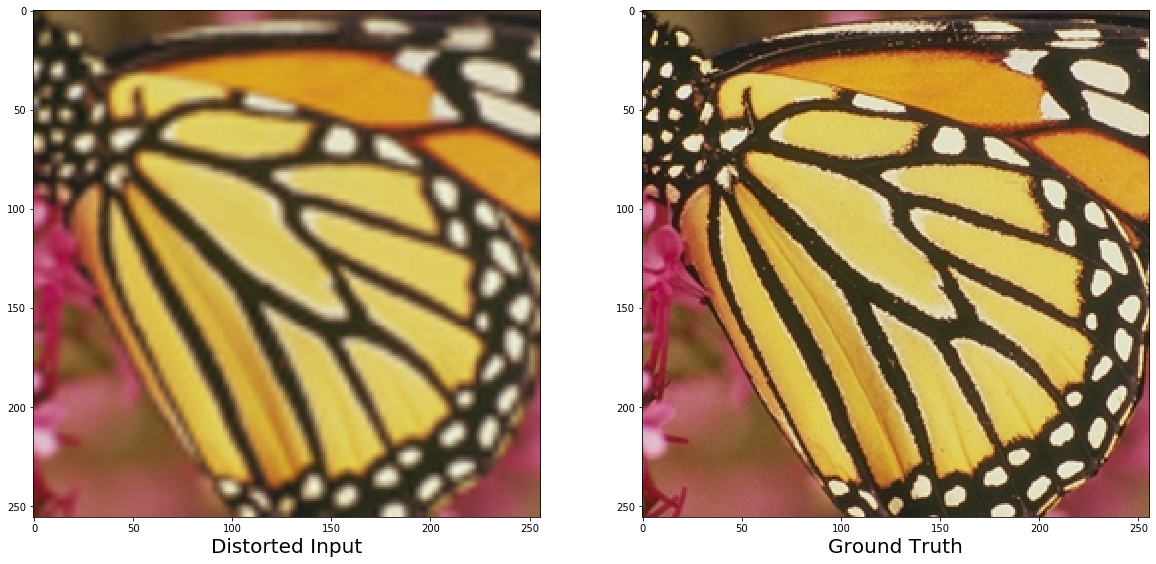

In [26]:

f, axarr = plt.subplots(1,2, figsize=(20, 20))
axarr[1].set_xlabel('Ground Truth', fontsize=20)
axarr[1].imshow(Image.fromarray(im, 'YCbCr'))

axarr[0].set_xlabel('Distorted Input', fontsize=20)
axarr[0].imshow(Image.fromarray(blurred_test_im, 'YCbCr'))

## Generate ground truth patches for distorted patches for training & val sets

In [27]:
training_img_names = [i for i in os.listdir('../../data/raw/BSDS500/data/images/train/') if i[-4:] == '.jpg']
training_images_gt_patches = []
for idx, img_name in enumerate(training_img_names):
    ImageFile = Image.open('../../data/raw/BSDS500/data/images/train/'+img_name)
    im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
    im_train_Y = im_train[:,:,0]
    #crop image to be multiple of 8 in both dims
    max_x = int(im_train_Y.shape[0]/8) * 8
    max_y = int(im_train_Y.shape[1]/8) * 8
    square_dim = min(max_x, max_y)
    im_train_Y = im_train_Y[0:square_dim, 0:square_dim]
    # need to extract to patches so that all images are the same size
    for i in range(0, im_train_Y.shape[1]-32, 13): #every patch vertically with stride 13
        for j in range(0, im_train_Y.shape[0]-32, 13):
            sub_im = im_train_Y[j:j+32, i:i+32]
            training_images_gt_patches.append(sub_im)

training_img_names = [i for i in os.listdir('../../data/raw/BSDS500/data/images/test/') if i[-4:] == '.jpg']
for idx, img_name in enumerate(training_img_names):
    ImageFile = Image.open('../../data/raw/BSDS500/data/images/test/'+img_name)
    im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
    im_train_Y = im_train[:,:,0]
    #crop image to be multiple of 8 in both dims
    max_x = int(im_train_Y.shape[0]/8) * 8
    max_y = int(im_train_Y.shape[1]/8) * 8
    square_dim = min(max_x, max_y)
    im_train_Y = im_train_Y[0:square_dim, 0:square_dim]
    # need to extract to patches so that all images are the same size
    for i in range(0, im_train_Y.shape[1]-32, 13): #every patch vertically with stride 13
        for j in range(0, im_train_Y.shape[0]-32, 13):
            sub_im = im_train_Y[j:j+32, i:i+32]
            training_images_gt_patches.append(sub_im)

# norm, standardize, and make tensor for training
training_images_gt_patches = np.array(training_images_gt_patches)
print(training_images_gt_patches.shape)

#normalize
training_images_gt_patches /= 255.0

train_pixel_mean = np.mean(training_images_gt_patches)
print(train_pixel_mean)
train_pixel_std = np.std(training_images_gt_patches)
print(train_pixel_std)
#standardize
training_images_gt_patches -= train_pixel_mean
training_images_gt_patches /= train_pixel_std

training_images_gt_patches = torch.tensor(training_images_gt_patches)

(211600, 32, 32)
0.43411854967058106
0.23247274722791464


In [28]:
training_img_names = [i for i in os.listdir('../../data/raw/BSDS500/data/images/train/') if i[-4:] == '.jpg']
training_images_training_patches = []
for idx, img_name in enumerate(training_img_names):
    ImageFile = Image.open('../../data/raw/BSDS500/data/images/train/'+img_name)
    im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
    im_train_Y = im_train[:,:,0]
    #crop image to be multiple of 8 in both dims
    max_x = int(im_train_Y.shape[0]/8) * 8
    max_y = int(im_train_Y.shape[1]/8) * 8
    square_dim = min(max_x, max_y)
    im_train_Y = im_train[0:square_dim, 0:square_dim, 0]
    im_train_Cb = im_train[0:square_dim, 0:square_dim, 1]
    im_train_Cr = im_train[0:square_dim, 0:square_dim, 2]
    
    # distort image with blur, downsize and upsize bicubic interpolation
    im_Y_blur = distort_image(path='../../data/raw/BSDS500/data/images/train/'+img_name, 
                              factor=SR_FACTOR, 
                              sigma=SIGMA)[0:square_dim, 0:square_dim, 0].astype(np.float)
    
    for i in range(0, im_Y_blur.shape[1]-32, 13): #every patch vertically with stride 13
        for j in range(0, im_Y_blur.shape[0]-32, 13):
            sub_im = im_Y_blur[j:j+32, i:i+32]
            training_images_training_patches.append(sub_im)

training_img_names = [i for i in os.listdir('../../data/raw/BSDS500/data/images/test/') if i[-4:] == '.jpg']
for idx, img_name in enumerate(training_img_names):
    ImageFile = Image.open('../../data/raw/BSDS500/data/images/test/'+img_name)
    im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
    im_train_Y = im_train[:,:,0]
    #crop image to be multiple of 8 in both dims
    max_x = int(im_train_Y.shape[0]/8) * 8
    max_y = int(im_train_Y.shape[1]/8) * 8
    square_dim = min(max_x, max_y)
    im_train_Y = im_train[0:square_dim, 0:square_dim, 0]
    im_train_Cb = im_train[0:square_dim, 0:square_dim, 1]
    im_train_Cr = im_train[0:square_dim, 0:square_dim, 2]

    # distort image with blur, downsize and upsize bicubic interpolation
    im_Y_blur = distort_image(path='../../data/raw/BSDS500/data/images/test/'+img_name, 
                              factor=SR_FACTOR, 
                              sigma=SIGMA)[0:square_dim, 0:square_dim, 0].astype(np.float)
    
    for i in range(0, im_Y_blur.shape[1]-32, 13): #every patch vertically with stride 13
        for j in range(0, im_Y_blur.shape[0]-32, 13):
            sub_im = im_Y_blur[j:j+32, i:i+32]
            training_images_training_patches.append(sub_im)
            
training_images_training_patches = np.array(training_images_training_patches)
print(training_images_training_patches.shape)

training_images_training_patches /= 255.0
training_images_training_patches -= train_pixel_mean
training_images_training_patches /= train_pixel_std

training_images_training_patches = torch.tensor(training_images_training_patches)
training_images_training_patches.shape


(211600, 32, 32)


torch.Size([211600, 32, 32])

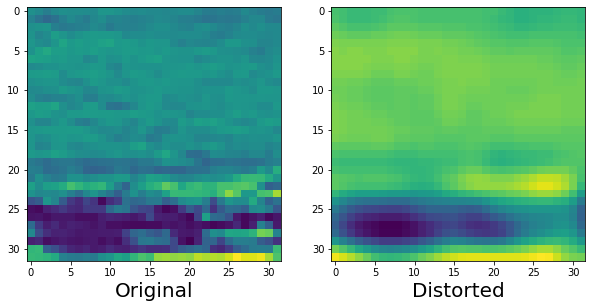

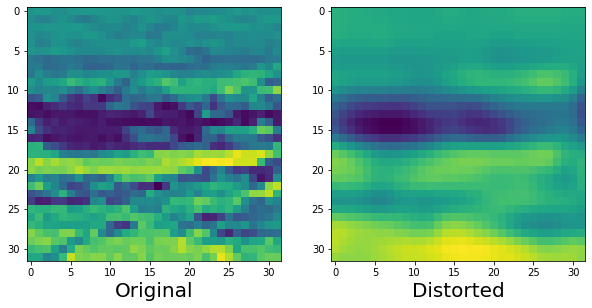

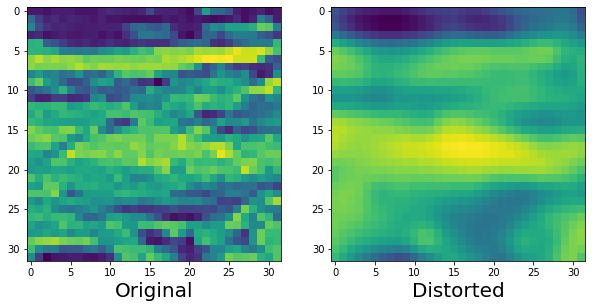

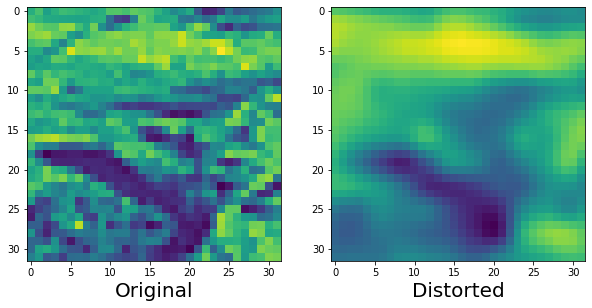

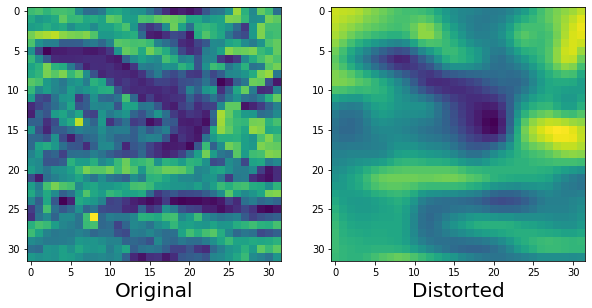

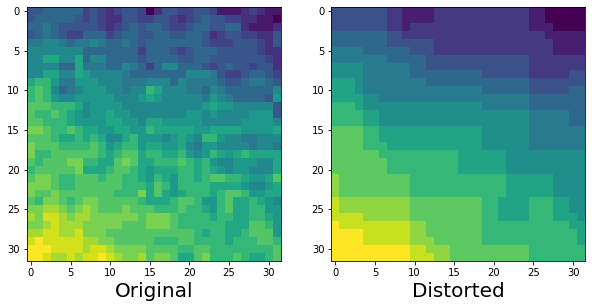

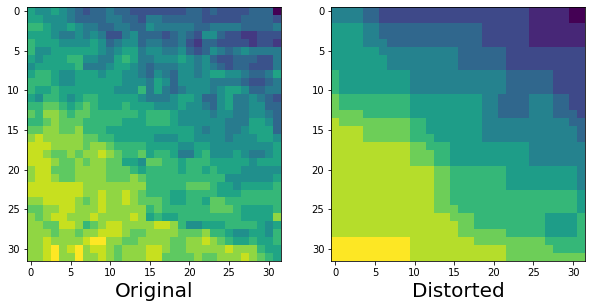

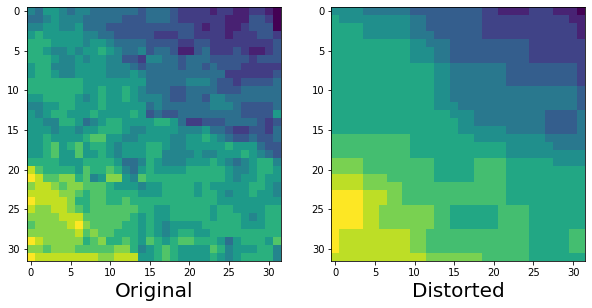

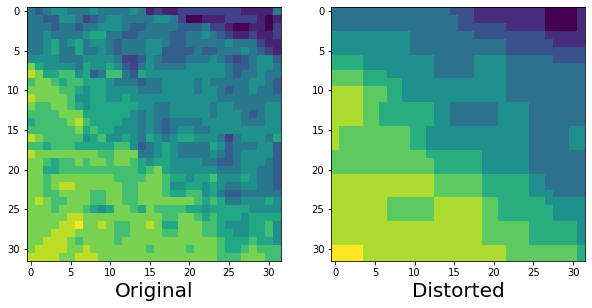

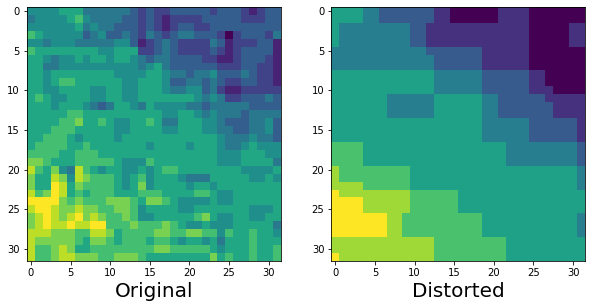

In [29]:
# sanity check on processing
for i in range(10000,10010):
    
    f, axarr = plt.subplots(1,2, figsize=(10, 10))
    axarr[0].imshow(training_images_gt_patches[i])
    axarr[0].set_xlabel('Original', fontsize=20)

    axarr[1].imshow(training_images_training_patches[i])
    axarr[1].set_xlabel('Distorted', fontsize=20)


In [30]:
my_training_dataset = data.TensorDataset(training_images_training_patches, training_images_gt_patches)
my_dataloader = data.DataLoader(my_training_dataset,
                                batch_size=128,
                                shuffle=True,
                                drop_last=True)

In [31]:
val_img_names = [img for img in os.listdir('../../data/raw/BSDS500/data/images/val/') if img[-4:] == '.jpg']
val_images_gt_patches = []
for idx, img_name in enumerate(val_img_names):
    ImageFile = Image.open('../../data/raw/BSDS500/data/images/val/'+img_name)
    im_val = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
    im_val_Y = im_val[:,:,0]
    #crop image to be multiple of 8 in both dims
    max_x = int(im_val_Y.shape[0]/8) * 8
    max_y = int(im_val_Y.shape[1]/8) * 8
    square_dim = min(max_x, max_y)
    im_val_Y = im_val_Y[0:square_dim, 0:square_dim]
    # need to extract to patches so that all images are the same size
    for i in range(0, im_val_Y.shape[1]-32, 13): #every patch vertically with stride 13
        for j in range(0, im_val_Y.shape[0]-32, 13):
            sub_im = im_val_Y[j:j+32, i:i+32]
            val_images_gt_patches.append(sub_im)
            
val_images_gt_patches = np.array(val_images_gt_patches)
print(val_images_gt_patches.shape)
#normalize
val_images_gt_patches /= 255.0
#standardize
val_images_gt_patches -= train_pixel_mean
val_images_gt_patches /= train_pixel_std

val_images_gt_patches = torch.tensor(val_images_gt_patches)
val_images_gt_patches.shape

val_images_val_patches = []
for idx, img_name in enumerate(val_img_names):
    ImageFile = Image.open('../../data/raw/BSDS500/data/images/val/'+img_name)
    im_train = np.array(ImageFile.convert('YCbCr'), dtype=np.float) 
    im_train_Y = im_train[:,:,0]
    #crop image to be multiple of 8 in both dims
    max_x = int(im_train_Y.shape[0]/8) * 8
    max_y = int(im_train_Y.shape[1]/8) * 8
    square_dim = min(max_x, max_y)
    im_train_Y = im_train[0:square_dim, 0:square_dim, 0]
    im_train_Cb = im_train[0:square_dim, 0:square_dim, 1]
    im_train_Cr = im_train[0:square_dim, 0:square_dim, 2]
    
    # distort image with blur, downsize and upsize bicubic interpolation
    im_Y_blur = distort_image(path='../../data/raw/BSDS500/data/images/val/'+img_name, 
                              factor=SR_FACTOR, 
                              sigma=SIGMA)[0:square_dim, 0:square_dim, 0].astype(np.float)

    for i in range(0, im_Y_blur.shape[1]-32, 13): #every patch vertically with stride 13
        for j in range(0, im_Y_blur.shape[0]-32, 13):
            sub_im = im_Y_blur[j:j+32, i:i+32]
            val_images_val_patches.append(sub_im)

val_images_val_patches = np.array(val_images_val_patches)
print(val_images_val_patches.shape)
#normalize
val_images_val_patches /= 255.0
#standardize
val_images_val_patches -= train_pixel_mean
val_images_val_patches /= train_pixel_std

val_images_val_patches = torch.tensor(val_images_val_patches)
val_images_val_patches.shape


(52900, 32, 32)
(52900, 32, 32)


torch.Size([52900, 32, 32])

In [32]:
my_val_dataset = data.TensorDataset(val_images_val_patches, val_images_gt_patches)
my_val_dataloader = data.DataLoader(my_val_dataset,
                                    batch_size=128,
                                    shuffle=True,
                                    drop_last=True)

## Determine frequency cooefficient differences

In [33]:
# calculate the perceptual weights
master_diff = np.zeros((8,8))
num_patches = 0
all_diff_patches = []
training_img_names = [i for i in os.listdir('../../data/raw/BSDS500/data/images/train/') if i[-4:] == '.jpg']
for i, im_name in enumerate(training_img_names):
    ImageFile = Image.open('../../data/raw/BSDS500/data/images/train/'+im_name)
    im = np.array(ImageFile.convert('YCbCr'))
    im_Y, im_Cb, im_Cr = im[:, :, 0], im[:, :, 1], im[:, :, 2]
    
    # distort image with blur, downsize and upsize bicubic interpolation
    im_Y_blur = distort_image(path='../../data/raw/BSDS500/data/images/train/'+im_name, 
                              factor=SR_FACTOR, 
                              sigma=SIGMA)[:, :, 0].astype(np.float)
    image_diff_patch = np.zeros((8,8))
    for i in range(0, im_Y.shape[1]-8, 8): #every patch vertically with stride 8
        for j in range(0, im_Y.shape[0]-8, 8):
            clear_patch = im_Y[j:j+8, i:i+8]
            clear_patch_dct = dct_2d(torch.tensor(clear_patch, dtype=torch.float).to(device), norm='ortho')
            blur_patch = im_Y_blur[j:j+8, i:i+8]
            blur_patch_dct = dct_2d(torch.tensor(blur_patch, dtype=torch.float).to(device), norm='ortho')

            patch_diff = torch.abs(blur_patch_dct - clear_patch_dct).cpu().numpy()
            patch_diff /= (((torch.abs(clear_patch_dct) + torch.abs(blur_patch_dct)).cpu().numpy())/2)+0.0000000000001

            master_diff += patch_diff
            image_diff_patch += patch_diff
            num_patches += 1
            all_diff_patches.append(patch_diff)

    plt.imshow(image_diff_patch)
    plt.show()

diff_patches = np.zeros((num_patches, 8, 8))
for i, patch in enumerate(all_diff_patches):
    diff_patches[i] = patch
plt.imshow(master_diff)

KeyboardInterrupt: 

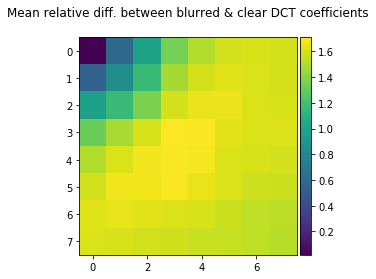

In [34]:
diff_means = torch.load('../../diff_means.pt')
#print(diff_means)
fig, ax = plt.subplots()
#
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(diff_means)
ax.set_title("Mean relative diff. between blurred & clear DCT coefficients\n")
fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()

## Define Loss

In [ ]:
# JPEGs perceptual model
qt_Y = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                 [12, 12, 14, 19, 26, 58, 60, 55],
                 [14, 13, 16, 24, 40, 57, 69, 56],  
                 [14, 17, 22, 29, 51, 87, 80, 62],  
                 [18, 22, 37, 56, 68, 109, 103, 77],   
                 [24, 35, 55, 64, 81, 104, 113, 92],  
                 [49, 64, 78, 87, 103, 121, 120, 101],  
                 [72, 92, 95, 98, 112, 100, 103, 99]])


In [ ]:
perceptual_weights = (np.ones_like(qt_Y)/qt_Y)*diff_means
perceptual_weights = torch.tensor(perceptual_weights).to(device)
perceptual_weights

In [ ]:
class FDPL_weighted(nn.Module):
    """
        Loss function taking the MSE between the 2D DCT coefficients
        of predicted and target images or an image channel.
        DCT coefficients are computed for each 8x8 block of the image
    
    """
    def __init__(self, perceptual_weights):
        """
            qt_Y (numpy.ndarray): the 8x8 quantization table used for JPEG compression
                on the luminance/Y clannel
        """
        super(FDPL_weighted, self).__init__()
        self.perceptual_weights = perceptual_weights


    def forward(self, predictions, targets):
        """
            Args:
                predictions (torch.tensor): output of an image transformation model.
                    shape: batch_size x 1 x H x W
                targets (torch.tensor): ground truth images corresponding to outputs
                    shape: batch_size x H x W
                criterion (torch.nn.MSELoss): object used to calculate MSE

            Returns:
                loss (float): MSE between predicted and ground truth 2D DCT coefficients
        """
        #get DCT coefficients of ground truth patches
        patches = extract_patches_2d(img=targets.unsqueeze(1), patch_shape=(8,8), batch_first=True)
        ground_truth_dct = dct_2d(patches, norm='ortho')

        #get DCT coefficients of transformed images
        patches = extract_patches_2d(img=outputs, patch_shape=(8,8), batch_first=True)
        outputs_dct = dct_2d(patches, norm='ortho')
        loss = torch.sum(((outputs_dct.double() - ground_truth_dct.double()).pow(2))*self.perceptual_weights)/64
        return loss

In [ ]:
# instantiate loss
criterion = FDPL_weighted(perceptual_weights).to(device)

## Define Model

In [ ]:
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4);
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1, padding=0);
        self.conv3 = nn.Conv2d(32, 1, kernel_size=7, padding=3);

    def forward(self, img):
        out = F.relu(self.conv1(img)) #n_1=64 feature maps
        out = F.relu(self.conv2(out)) #non linear mapping
        out = self.conv3(out)
        return out

In [ ]:
SR_model_FDPL = SRCNN().to(device)

optimizer = optim.SGD(
                      [
                          {"params": SR_model_FDPL.conv1.parameters(), "lr": 0.00005},
                          {"params": SR_model_FDPL.conv2.parameters(), "lr": 0.00005},
                          {"params": SR_model_FDPL.conv3.parameters(), "lr": 0.000005},
                      ], momentum=0.9)

checkpoint = torch.load('../../checkpoint_SR_with_FDPL_loss_mean.pt')
SR_model_FDPL.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['val loss']
epoch

## Train model

In [ ]:
# last check on data going into model & set up tensor board


# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
        
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        

writer = SummaryWriter('runs/SR_with_FDPL_demo')
my_dataloader2 = data.DataLoader(my_training_dataset, batch_size=4, shuffle=True, drop_last=True)

# get some random training images
dataiter = iter(my_dataloader2)
images, labels = dataiter.next()


images_2 = torch.zeros((4,3,32,32))
images_2[:,0,:,:] = images
images_2[:,1,:,:] = images
images_2[:,2,:,:] = images


# create grid of images
img_grid = torchvision.utils.make_grid(images_2, nrow=4)
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_training_images', img_grid)

writer.add_graph(SR_model_FDPL, images.unsqueeze(1).float().to(device))
writer.close()


In [ ]:
best_val_loss = 10000.0
global_epoch = 0

In [ ]:
for epoch in range(2): 
    print("epoch: ", global_epoch + 1)
    running_loss = 0.0
    for batch_i, data in enumerate(my_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, ground_truth = data
        inputs = inputs.float().to(device)
        ground_truth = ground_truth.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = SR_model_FDPL(inputs.unsqueeze(1))
        
        

        loss = criterion(outputs.squeeze(), ground_truth.float())
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if batch_i % 100 == 99:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (global_epoch + 1, batch_i + 1, running_loss / 100))
            writer.add_scalar('training loss', running_loss / 100,
                              global_epoch * len(my_dataloader) + batch_i)
            running_loss = 0.0
    
    #end of epoch metric calculations         
    global_epoch += 1
    with torch.no_grad():

        val_loss = 0
        batch_i = 0
        for batch_i, data in enumerate(my_val_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, ground_truth = data
            inputs = inputs.to(device)
            ground_truth = ground_truth.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = SR_model(inputs.float().unsqueeze(1))

            

            val_loss += criterion(outputs.squeeze(), ground_truth.float())
        
        #get average loss per batch, to match how loss is reported in training
        val_loss = val_loss/(len(my_val_dataloader))
        writer.add_scalar('validation loss', val_loss, global_epoch)
        
        print('epoch %d validation loss: %f'%(global_epoch, val_loss))
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            
            print("New lowest loss found. Saving checkpoint.")
#             torch.save({'epoch': global_epoch,
#                         'model_state_dict': SR_model.state_dict(),
#                         'optimizer_state_dict': optimizer.state_dict(),
#                         'val loss': val_loss
#                         }, './checkpoint_SR_with_FDPL_loss_mean.pt')
        # eval over a unrelated dataset to track psnr
        mean_blur_psnr, mean_sr_psnr = evaluate_model(path='./data/raw/test_sets/Set5/', 
                                                      model=SR_model_FDPL, 
                                                      pixel_mean=train_pixel_mean, 
                                                      pixel_std=train_pixel_std)
        writer.add_scalars('Test5 PSNR (dB)', {'bicubic_psnr':mean_blur_psnr,
                                               'srcnn_psnr':mean_sr_psnr}, global_epoch)
        print("test5: bicubic = %f; srcnn = %f"%(mean_blur_psnr, mean_sr_psnr))
            
            
print('Finished Training')

## Visualize training progress and kernels

In [ ]:
# start tb from ssh cmd line and check locally

In [ ]:
for params in SR_model_FDPL.named_parameters():
    print(params[1].shape)
    break

print("SR_with_FDPL_loss after %d epochs of training." % (epoch))
im = torch.ones((64,3,9,9))
im[:,0,:,:] = params[1].squeeze().detach()
im[:,1,:,:] = params[1].squeeze().detach()
im[:,2,:,:] = params[1].squeeze().detach()
img_grid = torchvision.utils.make_grid(im, nrow=8)

fig = plt.figure(figsize=(55, 55))
fig.subplots_adjust(left=0.05, right=0.95)
grid = ImageGrid(fig, 141,  # similar to subplot(141)
                 nrows_ncols=(8, 8),
                 axes_pad=0.05,
                 label_mode="1",
                 )
for i, ax in enumerate(grid):
    im = ax.imshow(params[1][i].squeeze().detach().cpu().numpy(), interpolation="none", cmap='Greys')


## Generate results

In [ ]:
SR_model_MSE = SRCNN().to(device)
checkpoint = torch.load('../../checkpoint_SRCNN_w_MSE.pt')
SR_model_MSE.load_state_dict(checkpoint['model_state_dict'])

In [ ]:

test5_img_names = [im for im in os.listdir('../../data/raw/test_sets/Set5/') if im[-4:] == '.bmp']

for test_im in test5_img_names:
    path = '../../data/raw/test_sets/Set5/' + test_im
    blurred_test_im = distort_image(path=path, factor=SR_FACTOR, sigma=1, blur=True)
    ImageFile = Image.open(path)
    im = np.array(ImageFile.convert('YCbCr')) 
    
    #normalize
    input = blurred_test_im[:,:,0] / 255.0
    #standardize
    input -= train_pixel_mean
    input /= train_pixel_std
    
    #MSE trained model output
    im_out_Y_MSE = SR_model_MSE(torch.tensor(input, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device))
    im_out_Y_MSE = im_out_Y_MSE.detach().squeeze().squeeze().cpu().numpy().astype(np.float)
    im_out_viz_MSE = np.zeros((im_out_Y_MSE.shape[0], im_out_Y_MSE.shape[1], 3))
    
    #unstandardize 
    im_out_Y_MSE = (im_out_Y_MSE * train_pixel_std) + train_pixel_mean
    #un-normalize
    im_out_Y_MSE *= 255.0
    #save for viz
    im_out_viz_MSE[:,:,0] = im_out_Y_MSE
    im_out_viz_MSE[:,:,1] = im[:,:,1]
    im_out_viz_MSE[:,:,2] = im[:,:,2]
    

    #FDPL trained model output
    im_out_Y = SR_model_FDPL(torch.tensor(input, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device))
    im_out_Y = im_out_Y.detach().squeeze().squeeze().cpu().numpy().astype(np.float)
    im_out_viz = np.zeros((im_out_Y.shape[0], im_out_Y.shape[1], 3))
    
    #unstandardize 
    im_out_Y = (im_out_Y * train_pixel_std) + train_pixel_mean
    #un-normalize
    im_out_Y *= 255.0
    #save for viz
    im_out_viz[:,:,0] = im_out_Y
    im_out_viz[:,:,1] = im[:,:,1]
    im_out_viz[:,:,2] = im[:,:,2]

    
    f, axarr = plt.subplots(1,4, figsize=(20, 20))
    axarr[0].set_xlabel('Original / PSNR', fontsize=20)
    axarr[0].imshow(Image.fromarray(im, 'YCbCr'))

    axarr[1].set_xlabel('Bicubic / ' + str(np.around(peak_signal_noise_ratio(ycbcr2rgb(im), ycbcr2rgb(blurred_test_im)),3)), fontsize=20)
    axarr[1].imshow(Image.fromarray(blurred_test_im, 'YCbCr'))
    
    axarr[2].set_xlabel('SRCNN / ' + str(np.around(peak_signal_noise_ratio(ycbcr2rgb(im), ycbcr2rgb(im_out_viz_MSE)),3)), fontsize=20)
    axarr[2].imshow(ycbcr2rgb(im_out_viz))
    
    axarr[3].set_xlabel('SRCNN-FDPL / ' + str(np.around(peak_signal_noise_ratio(ycbcr2rgb(im), ycbcr2rgb(im_out_viz)),3)), fontsize=20)
    axarr[3].imshow(ycbcr2rgb(im_out_viz))